In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure
from skimage import io as sk_io
plt.gray()
SEED=5512
None

In [2]:
# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-cytokit', 'output', 'v01')
# nuc_cyc = 0
# nuc_ch = 0
# nuc_ch_name = 'ch:HOECHST1'

# exp_name = '20180706-Donor22-R2-Tcell-CODEX_CD3CD4CD85BY5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01')
# nuc_cyc = 0
# nuc_ch = 0
# nuc_ch_name = 'ch:DAPI'

# exp_name = '20180802-Donor7_Tcell-CODEX_CD3CD4CD8_7BYB7'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v02')
# nuc_cyc = 0
# nuc_ch = 0
# nuc_ch_name = 'ch:DAPI'

exp_name = 'RS002_CODEX_Tonsil_180426'
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'wherrylab', exp_name)
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'wherrylab', exp_name, '2018_08_02_RS002_processed_cytokit', 'output', 'v01')
nuc_cyc = 1
nuc_ch = 0
nuc_ch_name = 'ch:HOECHST2'

In [3]:
#img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'hoechst'))
img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'best_z_segm'))
img_path

'/lab/data/wherrylab/RS002_CODEX_Tonsil_180426/2018_08_02_RS002_processed_cytokit/output/v01/montage/best_z_segm/R001.tif'

In [4]:
img = codex_io.read_tile(img_path)
img.shape

(1, 1, 6, 7620, 7620)

In [5]:
df = pd.read_csv(osp.join(exp_data_dir, codex_io.get_cytometry_agg_path('csv')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295443 entries, 0 to 295442
Data columns (total 49 columns):
region_index        295443 non-null int64
tile_index          295443 non-null int64
tile_x              295443 non-null int64
tile_y              295443 non-null int64
rid                 295443 non-null int64
rx                  295443 non-null float64
ry                  295443 non-null float64
id                  295443 non-null int64
x                   295443 non-null float64
y                   295443 non-null float64
z                   295443 non-null int64
cell_size           295443 non-null float64
cell_diameter       295443 non-null float64
cell_solidity       295443 non-null float64
nucleus_size        295443 non-null float64
nucleus_diameter    295443 non-null float64
nucleus_solidity    295443 non-null float64
ch:HOECHST1         295443 non-null float64
ch:CollagenIV       295443 non-null float64
ch:CD7              295443 non-null float64
ch:Ki67             295

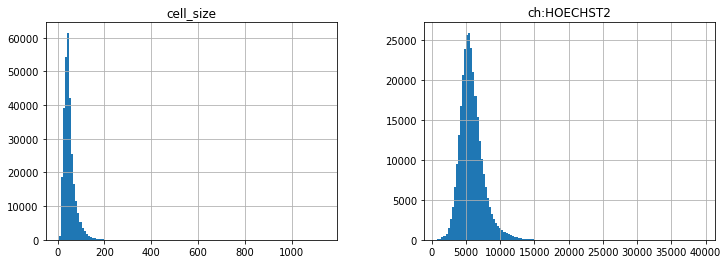

In [6]:
df[['cell_size', nuc_ch_name]].hist(figsize=(12, 4), bins=128)
None

In [7]:
from sklearn.preprocessing import PolynomialFeatures

def filter_by_pct(df, features, percents):
    ranges = df[features].quantile(q=percents)

    # Stack masks horizontally as dataframe
    print(ranges)
    mask = pd.concat([
        df[c].between(ranges[c].iloc[0], ranges[c].iloc[1])
        for c in ranges
    ], axis=1)
    
    return df[mask.all(axis=1).values]

filter_range = [.05, .95]
max_cells = 100000
dfm = filter_by_pct(df, ['cell_size', nuc_ch_name], filter_range)
if len(dfm) > max_cells:
    dfm = dfm.sample(n=max_cells, random_state=SEED)
            
X, y = dfm[['ry', 'rx']].copy(), dfm[nuc_ch_name] / dfm[nuc_ch_name].mean()

X.columns

      cell_size  ch:HOECHST2
0.05  21.425288  3463.377911
0.95  97.453856  8964.575174


Index(['ry', 'rx'], dtype='object')

In [8]:
len(X)

100000

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#est = GradientBoostingRegressor(n_estimators=300, random_state=SEED)
est = GradientBoostingRegressor(n_estimators=1000, random_state=SEED)
#est = DecisionTreeRegressor(random_state=SEED)
est.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=5512,
             subsample=1.0, verbose=0, warm_start=False)

In [10]:
#pd.Series(est.coef_, X.columns)

In [11]:
from skimage import transform

def get_pred_image(est, shape, step=1):
    r, c = shape
    ri, ci = np.arange(0, r, step), np.arange(0, c, step)
    ii = np.transpose([np.repeat(ri, len(ci)), np.tile(ci, len(ri))])
    X = pd.DataFrame(ii, columns=['ry', 'rx'])
    
    yp = est.predict(X)
    yp = yp.reshape((len(ri), len(ci)))

    if step > 1:
        print('Resizing')
        yp = transform.resize(yp, shape, mode='constant', order=0, anti_aliasing=False, preserve_range=False)
        
    assert yp.shape == (r, c)
    return yp

In [12]:
yp = get_pred_image(est, img.shape[-2:], step=10)

Resizing


In [13]:
yp.shape

(7620, 7620)

In [162]:
r, c = img.shape[-2:]
ii = np.transpose([np.repeat(np.arange(r), c), np.tile(np.arange(c), r)])
Xp = pd.DataFrame(ii, columns=['ry', 'rx'])
Xp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58064400 entries, 0 to 58064399
Data columns (total 2 columns):
ry    int64
rx    int64
dtypes: int64(2)
memory usage: 886.0 MB


In [163]:
Xp['ry'].max(), Xp['rx'].max()

(7619, 7619)

In [164]:
yp = est.predict(Xp)
print(pd.Series(yp).describe())
yp = yp.reshape(img.shape[-2:])
yp.shape

KeyboardInterrupt: 

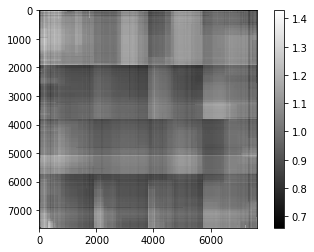

In [14]:
plt.imshow(yp)
plt.colorbar()

In [145]:
# plt.set_cmap('viridis')

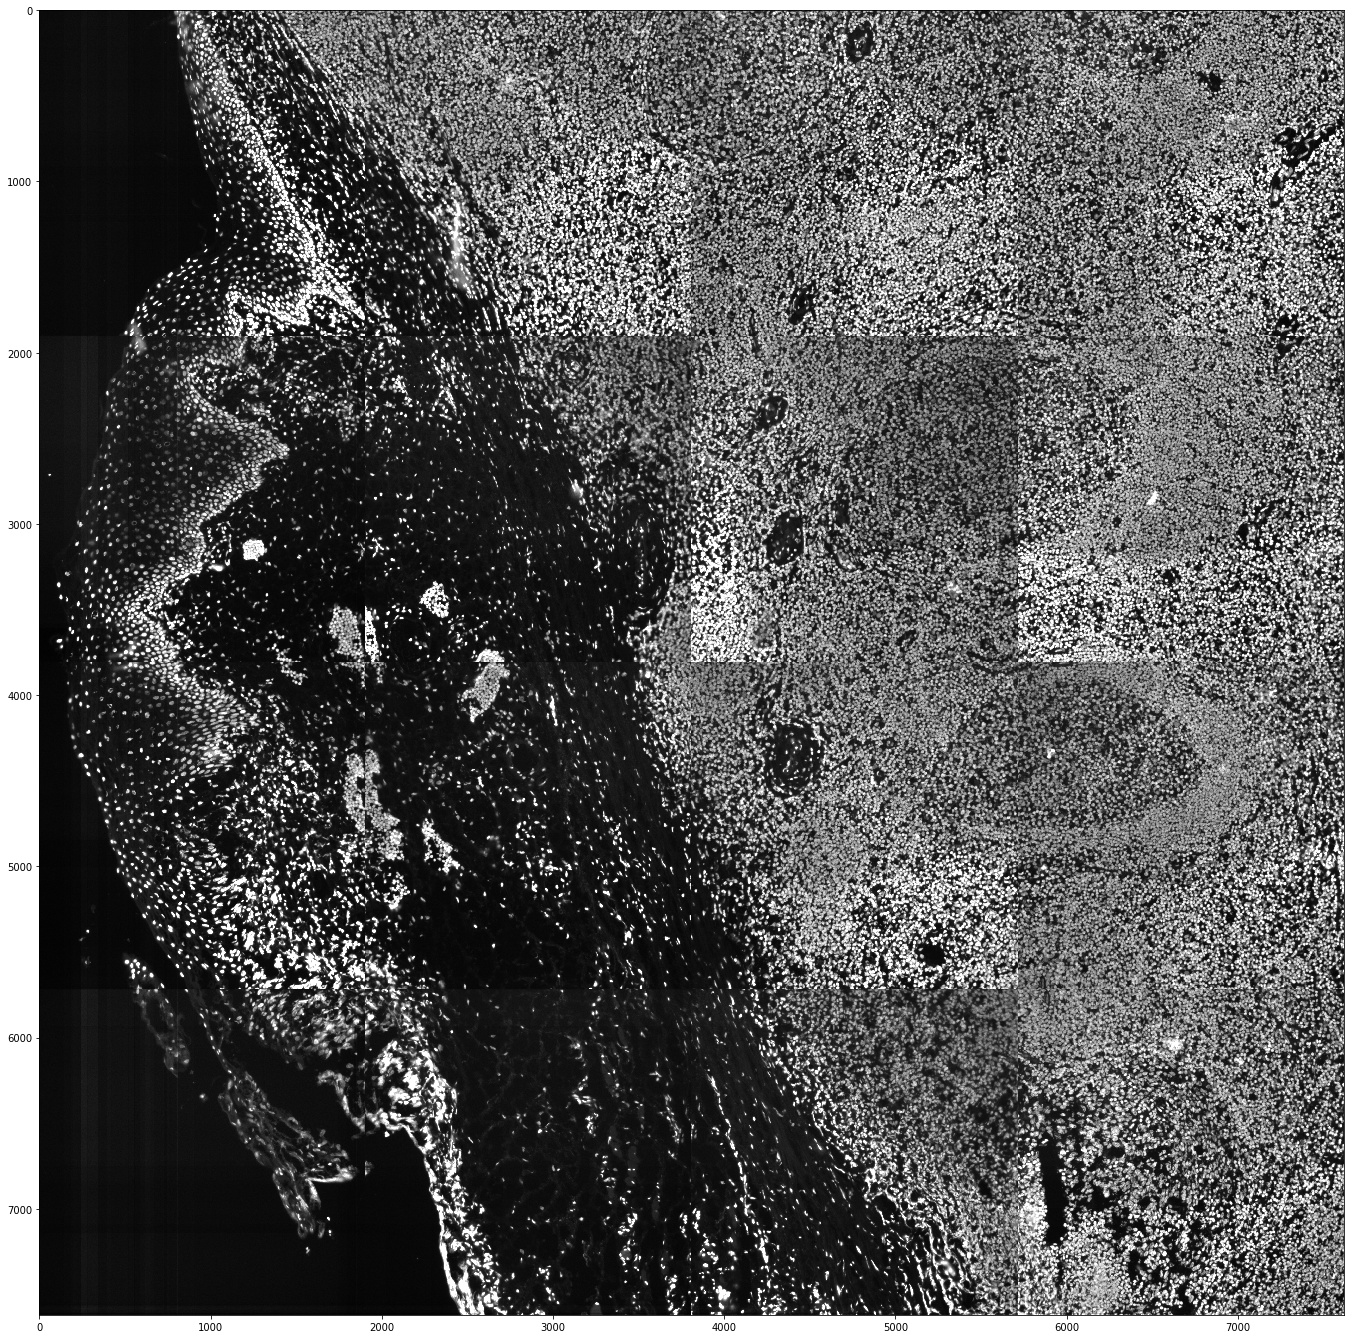

In [15]:
#plt.imshow(img[0, 0, 7])
plt.imshow(img[0, 0, 5].clip(0, 10000))
plt.gcf().set_size_inches(24, 24)

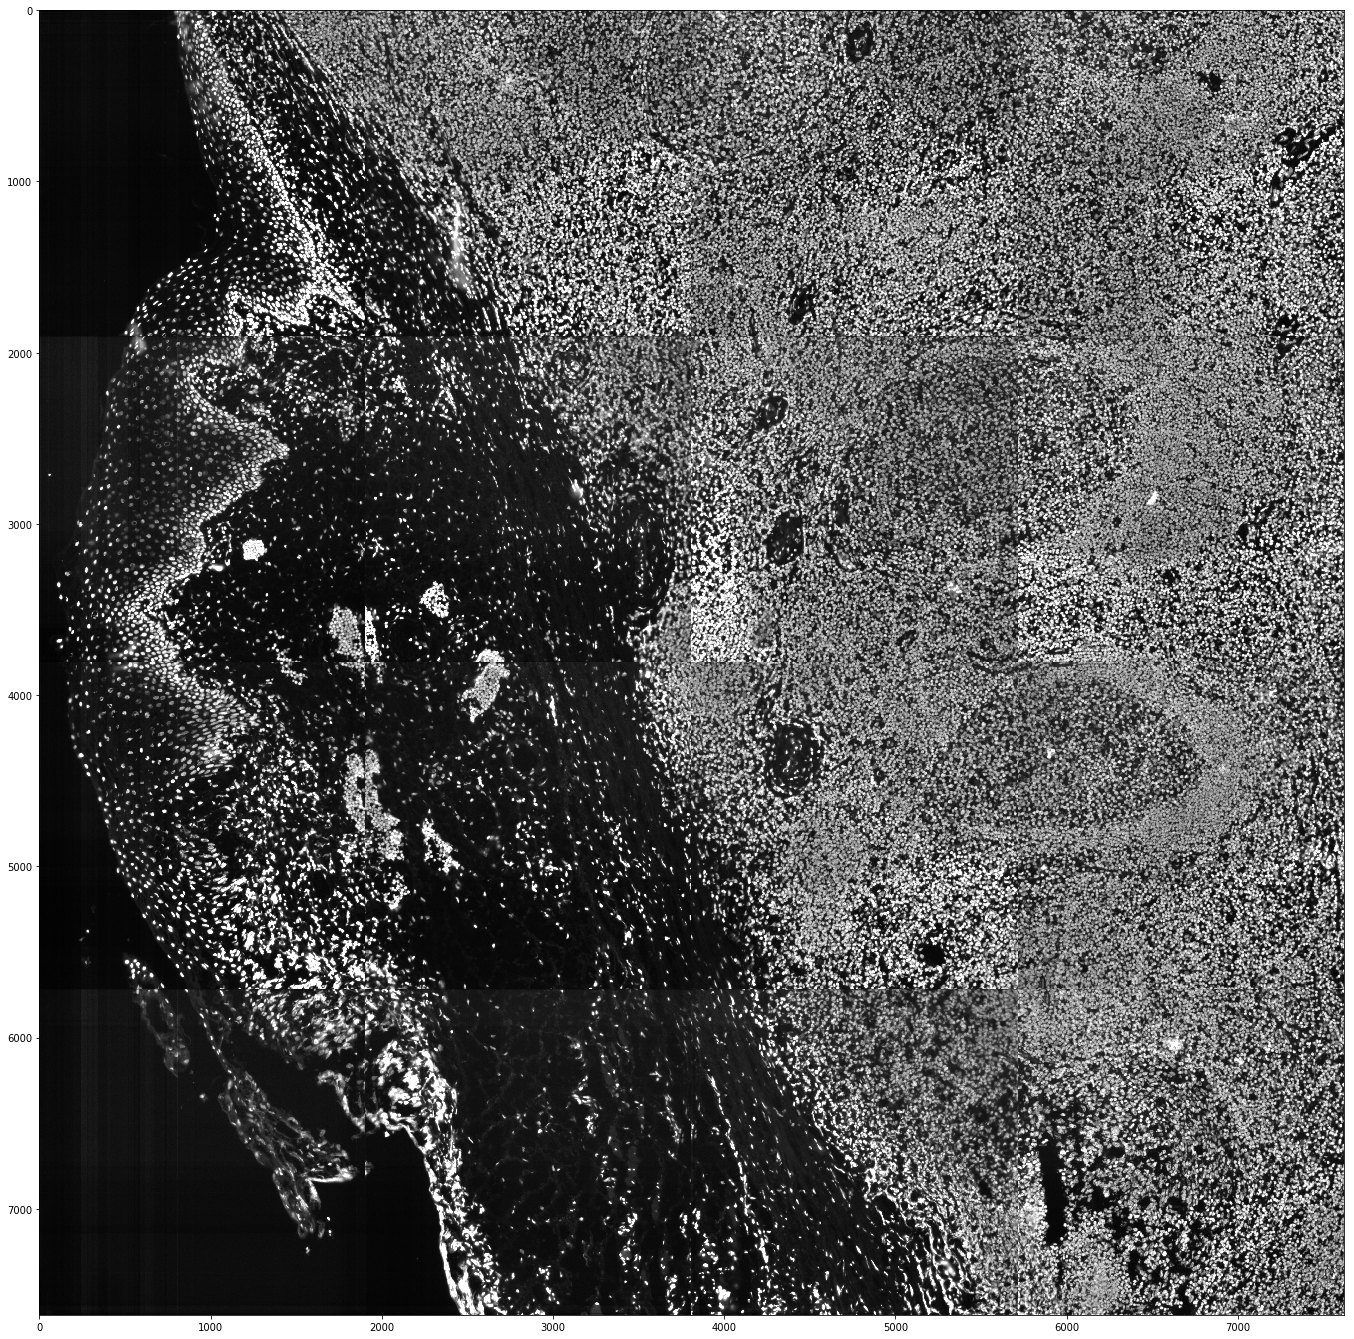

In [16]:
#img_ic = img[0, 0, 7] / yp
img_ic = img[0, 0, 5] / yp
plt.imshow(img_ic.clip(0, 10000))
plt.gcf().set_size_inches(24, 24)